# Symbolic Expressions

## Contents

+ Modeling algebraic expressions as data structures.
+ Writing code to analyze, transform, or evaluate algebraic expressions.
+ Finding the derivative of a function by manipulating the expression that defines it.
+ Writing a Python function to compute derivative formulas.
+ Using [SymPy](https://www.sympy.org/en/index.html) to compute integral formulas.

## Intro

The previous two chapters introduces two of the most important concepts in calculus: the derivative and the integral.

We saw that you can approximate the derivative of a function at a point by taking slopes of smaller and smaller secant lines. We also saw that you can approximate the integral of a function by estimating the area under the graph with skinnier and skinnier rectangles.

Up until now we've worked with approximations, because we were relying on the capacity of Python running on a computer, but Calculus teaches us how to obtain exact values for the derivative and integral.

For example, if $ f(x) = x^3 $, Calculus tells us that:

$
f'(x) = 3 \cdot x^2
$

There are formulas for each type of function, that you would apply when asked for the exact derivative of a function.

However, as developers, knowing the formulas is not a very interesting skill for us. Instead, we can realy on a specialized tool called *computer algebra system* to compute it for us.

## Finding an exact derivative with a computer algebra system

Mathematica is one of the most popular computer algebra systems. Its engine is free only at [Wolfram Alpha](https://www.wolframalpha.com/).

This site can be used to find the exact formula for a derivative.

For example, when building neural networks, it's useful to know the derivative of the function:

$
\displaystyle
f(x) = \frac{1}{1 + e^{-x}}
$

This can be easily obtained by entering that formula in Python syntax. After pressing enter, it will display several facts about the function, including its derivative:

![Entering formula](pics/wolfram-alpha-input-formula.png)

![Derivative and Integral](pics/wolfram-alpha-derivative-integral.png)

Mathematica does not rely on the approximations we've worked on the previous chapters. Instead, Wolfram Alpha interprets the formula you've typed in, transforms it with some algebraic manipulations, and outputs a new formula.

This is called **symbolic programming**.

### Doing symbolic algebra in Python

Let's start by illustrating how we will be representing and manipulating formulas in Python.

Let's assume we have a mathematical function like:

$
f(x) = (3 x^2  + x) \cdot sin(x)
$

We already know that the best way to represent the formula in order to evaluate it would be:

```python
from math import sin

def f(x):
  return (2 * x ** 2 + x) * sin(x)
```

But that representation is not helpful to learn facts about the formula, such as:

+ Does the formula depend on the variable x?
+ Does it contain a trigonometric function?
+ Does it involve the operation of division?

While we can really easily answer those questions just by looking at the function, the Python representation used to get the function values wouldn't help.

For example, it'd be very difficult to write a function `contains_division(f)` that returns true if it uses the operation division in its definition.

Thus, we need to find another way to represent the function. We need another way to express the function that would tell us what operations are being applied and in what order.

For instance, the function $ f(x) $ above is a product of $ sin(x) $ with a sum. We also know that there's a well-known algebraic process for expanding the function definition:

$
f(x) = (3 x^2  + x) \cdot sin(x) = 3 x^2 \cdot sin(x) + x \cdot sin(x)
$

The new way to represent the formula should let us apply those rules as well.

In summary, we need to *model algebraic expressions as data structures* so that we can manipulate them symbolically, and therefore automate the rules of calculus.

Once we have that, we will be able to calculate derivatives.

Most functions expressed by simple formulas also have simple formulas for their derivatives. For example, if $ f(x) = x^3 $, $ f'(x) = 3 \cdot x^2 $.

That means that the derivative of $ x^3 $ at any value of $ x $ is $ 3 \cdot x^2 $.

Another requirement for our data structures is that we will have to be able to calculate the derivative or any given algebraic expression.

At the minimum, we will need to represent variables, numbers, sums, differences, products, quotients, powers, and functions such as sine and cosine and take the derivatives of them.

## Modeling algebraic expressions

Let's develop our intuition around how we can break an algebraic expression such as $ f(x) = (3 \cdot x^2 + x) \cdot sin(x) $.

It contains the following building blocks we should model:
+ a variable $ x $
+ numbers ($ 3 $)
+ operations: addition, multiplication, power
+ a named function: $ sin(x) $

The goal is to translate it into a Python data structure we can work with.

The first observation is that $ f $ is an arbitrary name. The right hand side will evaluate the same whether the function is called $ f $, $ g $, or $ h $.

As a result, we should be focusing on the right hand side of the function definition, which is called an expression:
> An expression is a collection of mathematical symbols combined in some valid ways.

### Breaking an expression into pieces

The way in which we can model algebraic expressions such as $ (3 \cdot x^2 + x) \cdot sin(x) $ is to break them into smaller expressions.

There is only one meaningful way to break up the expressions $ (3  \cdot x^2 + x) \cdot sin(x) $. Namely, it's the product of $ (3 \cdot x^2 + x) $ and $ sin(x) $.

Other ways of breaking up the expression will end up in something we can't make sense of according to mathematical rules:

![Breaking up expressions](pics/breaking_expressions.png)

If we apply the same strategy to the expression $ 3 \cdot x^2 + x $ we will see that it can be broken down as:

![expression tree](pics/expression_tree.png)

If we inspect the approach we see that we take:
+ operations &mdash; ways to take two or more algebraic expressions and stick them together side by side to make a new, bigger algebraic expression.
+ operators &mdash; valid places to break up an existing algebraic expression into smaller ones.


In the terminology of functional programming, functions combining smaller objects into bigger ones like this are often called *combinators*.

Some of the combinators we've used in the expression above are:
+ $ 3 \cdot x^2 $ is the product of the expression 3 and $ x^2 $
+ $ x^2 $ is a power: one expression $ x $ raise to the power of another expression $ 2 $.
+ $ sin(x) $ is a *function application*. Given the expression $ sin $ and the expression $ x $, we can build a new expression $ sin(x) $.

By contrast, a variable $ x $, a number $ 2 $, or a function named $ sin $ cannot be broken down further, and we call them *elements*.

### Building an expression tree

Let's focus on the expression $ (3 \cdot x^2 + x) \cdot sin(x) $. The elements $ 3 $, $ x $, $ 2 $, and $ sin $, along with the combinators $ adding $, $ multiplying $, $ \text{raising to a power} $, and $ \text{applying a function} $ are sufficient to rebuild the whole expression.

One of the first sub-expressions we can put together is $ x^2 $, which combines $ x $ and $ 2 $ with the $ power $ combinator. We can picture it as below:

![Subexpression 1](pics/subexpression_1.png)

Note how the subexpression is represented as a tree with the combinator at the root, and leaves $ x $ and $ 2 $.

A good next step would be to represent $ 3 \cdot x^2 $, which we could also represent visually as below:

![Subexpression 2](pics/subexpression_2.png)

Note how it still has the aspect of a tree, and that the left leave of the $ Product $ combinator is itself the previous tree that represented $ x^2 $.

We can add one more layer to the tree to represent the $ 3 \cdot x^2 + x $ expression:

![Subexpression 3](pics/subexpression_3.png)

Finally, we can represent the whole $ (3 \cdot x^2 + x) \cdot sin(x) $ by introducing the $ Apply $ combinator and the known $ Product $ combinator:

![Subexpression 4](pics/subexpression_4.png)

![Final expression](pics/expression.png)

Note how the tree reveals the structure of the algebraic expression. The root of the tree is the $ Product $ combinator, with two branches coming out of it: $ Sum $ and $ Apply $. 

Each combinator appearing further down the tree adds additional branches until you reach the elements that are leaves and have no branches. And all we have used are numbers, variables, named functions and operations (as combinators).

### Translating the expression tree to Python

We can use Python classes to represent each kind of element and each kind of combinator. As we go along, we will be revising their implementation to give them more and more functionality.

The idea is to model combinators as containers that hold their required inputs. For example, to model the $ Power $ combinator, we can do:

```python
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent
```

That would allow us to write `Power("x", 2)`, but because we're dealing with symbolic expressions, it's even better to define special container classes for variables and numbers:

```python
class Number():
    def __init__(self, number):
        self.number = number

class Variable():
    def __init__(self, symbol):
        self.symbol = symbol
```

The will let us represent $ x^2 $ in Python as `Power(Variable("x"), Number(2))`.

It is easy now to extend the previous approach to represent the $ Product $ operation:

```python
class Product():
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2
```

So that $ 3 \cdot x^2 $ can now be written as:

```python
Product(Number(3), Power(Variable("x"), Number(2)))
```

We can now define the rest of combinators:

```python
class Sum():
    def __init__(self, *exprs):
        self.exprs = exprs

class Function():
    def __init__(self, name):
        self.name = name

class Apply()
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument
```

With those elements in place, we can faithfully represent the expression $ (3 \cdot x^2 + x) \cdot sin(x) $:

```python
expr = Product(
    Sum(
        Product(
            Number(3),
            Power(Variable("x"), Number(2))
        ),
        Variable("x")
    ),
    Apply(
        Function("sin"),
        Variable("x")
    )
)
```

By faithfully, we mean that we can have a look at the Python object and understand that it described the algebraic expression $ (3 \cdot x^2 + x) \cdot sin(x) $ and no other.

We started from an algebraic expression and built a Python object that uniquely and unequivocally.

We can also follow the opposite journey: start from a Python object and get to the algebraic expression it represents:

```python
Apply(Function("cos"),Sum(Power(Variable("x"),Number("3")), Number(−5)))
```

This represents the expression:

$
cos(x^3 - 5)
$

### Exercise

The natural algorithm, a special mathematical function, is written as $ ln(x) $.
Draw the expression $ ln(yz) $ as an expression tree built from the elements and combinators introduced in the previous section.



The tree can be displayed as:

![ln(yz) expr](pics/expr_lnyz.png)

The equivalent Python object will be:

```python
Apply(
    "ln",
    Product(
        Variable("y"),
        Variable("z")
    )
)
```


### Exercise

Consider the mathematical expression $ ln(y^z) $. Draw the expression tree.

Then, translate the expression into Python code, given that the natural algorithm is calculated by the Python function `math.log`. Write it as a Python object using the classes defined in the previous exercise.

The expression tree is the following:

![ln(y^z)](pics/expr_ln_y_power_z.png)

The Python function can be defined as follows:

In [2]:
import math

def fn(y, z):
    return math.log(y ** z)

print(fn(2, 3))
print(math.log(8))

2.0794415416798357
2.0794415416798357


And the expression tree using the classes defined above is:

```python
Apply(
    Function("ln"),
    Power(
        Variable("y"),
        Variable("z")
    )
)
```

### Exercise

What is the expression represented by `Product(Number(3), Sum(Variable("y"), Variable("z")))`?

The Python expression above is equivalent to the mathematical expression:

$
3 \cdot (y + z)
$

Note that the parentheses are not required in the Python expression but needed in the equivalent mathematical expression because $ \cdot $ has greater precedence than $ + $.

### Exercise

Implement a `Quotient` combination representing one expression divided by another. How do you represent the following expression?

$$
\frac{a + b}{2}
$$

We can follow the same approach we used for other binary combinators:

```python
class Quotient():
    def __init__(self, numerator_expr, denominator_expr):
        self.numerator_expr = numerator_expr
        self.denominator_expr = denominator_expr
```

Then we can write:

```python
Quotient(
    Sum(
        Variable("a"),
        Variable("b")
    ),
    Number(2)
)
```

### Exercise

Implement a `Difference` combinator representing one expression subtracted from another. How can you represent the expression $ b^2 - 4ac $?

We can follow the same approach used for the other binary combinators:

```python
class Difference:
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2
```

Then, the given expression can be written as:

```python
Difference(
    Power(
        Variable("b"),
        Number(2)
    ),
    Product(
        Number(4),
        Product(
            Variable("a"),
            Variable("c")
        )
    )
)
```

### Exercise

Implement a `Negative` combinator representing the negation of an expression. For example, the negation of $ x^2 + y $ is $ -(x^2 +  y) $. Represent the latter expression using your new combinator.

This time we are dealing with a *unary* combinator, but the approach is similar:

```python
class Negative:
    def __init__(self, expr):
        self.expr = expr
```

And the representation will be:

```python
Negative(
    Sum(
        Power(
            Variable("x"),
            Number(2)
        ),
        Variable("y")
    )
)
```

### Exercise

Add a function called `Sqrt` that represents a square root and use it to encode the following formula:

$$
\frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

We can define the `Sqrt` function in the same way we define the `sin`:

```python
Sqrt = Function("sqrt")
```

Then the expression can be defined as:

```python
Quotient(
    Sum(
        Negative(Variable("b")),
        Apply(
            Sqrt,
            Difference(
                Power(
                    Variable("b"),
                    Number(2)
                ),
                Product(
                    Number(4),
                    Product(
                        Variable("a"),
                        Variable("c")
                    )
                )
            )
        )
    ),
    Product(
        Number(2),
        Variable("a")
    )
)
```

### Exercise

Create an abstract base class called `Expression` and make all of the elements and combinators inherit from it.

Then overload the Python arithmetic operations (`+`, `-`, `*`, and `/`) so that they produce `Expression` objects.

After the change, the code `2 * Variable("x") + 3` should yield `Sum(Product(Number(2), Variable("x")), Number(3))`.

## Putting a symbolic expression to work

For the function $ f(x) = (3x^2 + x) \cdot sin(x) $ we wrote a Python function that computes it:

In [2]:
from math import sin


def f(x):
    return (3 * x ** 2 + x) * sin(x)

f(1)

3.365883939231586

This representation is only good for returning an output value given an input value $ x $ and nothing more &mdash; it won't be easy to expand it algebraically, check whether the function contains trigonometric functions, etc.

Alternatively, we've seen that we can define classes to translate the function $ f(x) = (3x^2 + x) \cdot sin(x) $ into a Python data structure built from elements and combinators. That representation will let us answer those questions.

### Finding all the variables in an expression

Let's start by writing a function that takes an expression and returns a list of distinct variables that appear in it.

For example $ h(z) = 2z + 3 $ is defined using $ z $, while $ g(x) = 7 $ contains no variables.

Let's write a function `distinct_variables` that takes an expression and returns a Python set containing the variables.

Thus, we expect the following results:

```python
distinct_variables(Variable("z"))
{'z'}

distinct_variables(Number(3))
set()
```

While it is easy for the human eye to identify that in an expression $ y \cdot z + x^z $ the variables are $ x $, $ y $, and $ z $, it's quite tricky to come up with an algorithm that does so.

We could use a recursive solution for the implementation of `distinct_variables`:

```python
"""Utility functions for symbolic expressions."""

from symexpr.expressions import (
    Apply,
    Difference,
    Expression,
    Negative,
    Number,
    Power,
    Product,
    Quotient,
    Sum,
    Variable,
)


def distinct_variables(expr: Expression) -> set[str]:
    if isinstance(expr, Variable):
        return set(expr.name)
    elif isinstance(expr, Number):
        return set()
    elif isinstance(expr, Sum):
        return set().union(
            distinct_variables(expr.left), distinct_variables(expr.right)
        )
    elif isinstance(expr, Difference):
        return set().union(
            distinct_variables(expr.left), distinct_variables(expr.right)
        )
    elif isinstance(expr, Product):
        return set().union(
            distinct_variables(expr.left), distinct_variables(expr.right)
        )
    elif isinstance(expr, Quotient):
        return distinct_variables(expr.numerator).union(
            distinct_variables(expr.denominator)
        )
    elif isinstance(expr, Power):
        return distinct_variables(expr.base).union(
            distinct_variables(expr.exponent)
        )
    elif isinstance(expr, Negative):
        return distinct_variables(expr.expr)
    elif isinstance(expr, Apply):
        return distinct_variables(expr.expr)
    else:
        raise TypeError(f"Unknown expression type: {type(expr)}")
```

While the implementation looks hairy, it works!

It's actually a recursive traversal of the expression tree. By the time this function compleltes, it has called `distinct_variables` on every expression contained in the target expression, which are all of the nodes in the tree.

That ensures that we see every variable and that we get the correct answers that we expect.

### Evaluating an expression

It turns out that the tree representation of an expression can also be used to evaluate $ f(x) $ as well, although it requires a little more work. By contrast, implementing a function such as `distinct_variables` using the `def f(x)` representation of the function would be almost impossible.

Mechanically, evaluating a function $ f(x) $ at $ x = 5 $ means plugging in the value of 5 for $ x $ everywhere and then doing the arithmetic to find the result.

For example, if $ f(x) = x $, plugging in $ x = 5 $ should tell us $ f(5) = 5 $. Another simple example, $ g(x) = 7 $, plugging in $ x = 5 $ should tell us $ g(5) = 7 $.

The code to evaluate the expression in the tree is similar to the code we just wrote for finding the variables. The only difference is that we need to evaluate each subexpression, then the combinators will tell us how to combine the result to get the value of the whole expression.

The starting data we need is:
+ What values to plug in
+ What variables these replace

For example, an expression such as $ z(x, y) = 2xy^3 $ will need two values to get a result, as in $ x = 3 $, and $ y = 2 $. In Computer Science these are called *variable bindings*.

When those bindings are established, we can say $ z(3, 2) = 48 $, and the way to evaluate it would be to traverse the tree, returning the result of the evaluation taking into account the given *variable bindings*:

![Evaluating the tree](pics/evaluating_tree.png)

Note how the tree traversal effectively visits all nodes collecting pieces of the evaluation that are finally considered for the final evaluation.

While we could create an `utils` function such as `distinct_variables`, this time we will instead make all the `Expression` classes implement an `evaluate` method that will allow us to distribute the responsibilities of the evaluation to the corresponding element and combinator classes.

```python
from abc import ABC, abstractmethod


class Expression(ABC):

    @abstractmethod
    def evaluate(self, **bindings):
        pass
```

See that we decided that the user should pass the *variable bindings* using `*kargs*` as in:

```python
z.evaluate(x=3, y=2)
```

With the `evaluate()` signature in place, we can start implementing the function on each and every class in the hierarchy.

Variables and numbers are trivial:

```python
class Variable(Expression):
    ...
    def evaluate(self, **bindings):
        try:
            return bindings[self.name]
        except KeyError as e:
            raise KeyError(f"Variable {self.name!r} not bound.")

    ...

class Number(Expression):
    ...

    def evaluate(self, **bindings):
        return self.value
```

Now we can start implementing the `evaluate()` function in our combinators. Note that we will need to keep `Function` out of our `Expression` hierarchy class, because a function like *sine* is not a standalone expression. It will be used instead to validate that the user relies only on a few well-known functions such as `sqrt`, `sin`, `cos`, etc.

```python
# note that it doesn't extend `Expression` base class
class Function():
    ...
```

A function will only be able to be evaluated in the context of an `Apply` combinator. Which we will implement by calling the function:
```python
_well_known_function_bindings = {
    "sin": math.sin,
    "cos": math.cos,
    "tan": math.tan,
    "log": math.log,
    "sqrt": math.sqrt,
}

class Apply(Expression):

    def __init__(self, function: Function, argument: Expression):
        self.function = function
        self.argument = argument

    def evaluate(self, **bindings):
        return _well_known_function_bindings[self.function.name](
            self.argument.evaluate(**bindings)
        )
```

The rest of the combinators will follow the same approach:
+ evaluate the corresponding expression(s) involved
+ apply the corresponding operation (sum, subtract, negate, ...)

For example, the `Product` will be implemented as:

```python
class Product(Expression):

    def __init__(self, left: Expression, right: Expression):
        self.left = left
        self.right = right

    def evaluate(self, **bindings):
        return self.left.evaluate(**bindings) * self.right.evaluate(**bindings)
```

After that we will be able to evaluate expressions in the same way we'd do with regular Python functions:

In [1]:
from math import sin

def f(x):
    return (3 * x ** 2 + x) * sin(x)

f(5)

-76.71394197305108

In [4]:
from symexpr import Product, Sum, Power, Variable, Function, Apply, Number

expr_f = Product(
    Sum(
        Product(
            Number(3),
            Power(Variable("x"), Number(2))
        ),
        Variable('x')
    ),
    Apply(Function("sin"), Variable("x"))
)

print(expr_f.evaluate(x=5))

-76.71394197305108


### Expanding an expression

Once an algebraic expression is represented as a tree it is easy to operate with it as a mathematical expression and do things such as expanding it.

By expanding an expression we mean taking any product or power of sums and carrying it out, and the relevant rule of algebra for that is the distributive property of sums and products:

$
(a + b) \cdot c = ac + bc
$

For instance, for the expression:

$
(3x^2 + x) \cdot sin(x) = 3x^2 \cdot sin(x) + x \cdot sin(x)
$

Things can get more complicated in expressions such as the following, in which you need to apply the property several times

$
(x + y)^3 = (x + y) \cdot (x + y) \cdot (x + y) \\
= x \cdot [(x + y) \cdot (x + y)] + y \cdot [(x + y) \cdot (x + y)] \\
= x \cdot [x \cdot (x + y) + y \cdot (x + y)] + y \cdot [x \cdot (x + y) + y \cdot (x + y)] \\
= x \cdot (x^2 + xy + xy + y^2) + y \cdot (x^2 + xy + xy + y^2) \\
= x^3 + 2x^2y + x y^2 + x^2y + 2xy^2 + y^3 \\
= x^3 + y^3 + 3x^2y + 3xy^2
$

Note that it took a lot of writing and applying expansion, simplification, and the rewriting of some products (such as combining $xyx$ as $x^2y$, because order does not matter in multiplication).

In the following example though, we will only look at the expansion, not at the simplification.

We start by adding an abstract `expand()`  to the `Expression` class:

```python
class Expression(ABC):
...
    def expand(self):
        pass
```

And then we start implementing what it means to expand for each and every concrete class.

For example, if the expression is a variable or a number, it is already expanded:

```python
class Variable(Expression):
...
    def expand(self) -> Expression:
        return self

class Number(Expression):
...
    def expand(self) -> Expression:
        return self
```

Sums are already considered expanded expressions, but the individual terms of a sum might need to be expanded as in $ 5 + a(x + y) $.

Therefore, we can implement the expansion as follows:

```python
class Sum(Expression):
...
    def expand(self):
        return Sum(self.left.expand(), self.right.expand())
```

Same reasoning can be used for function application &mdash; the function application itself cannot be expanded but we can expand its arguments:

```python
class Apply(Expression):
...
    def expand(self):
        return Apply(self.function, self.argument.expand())
```

Implementing the expansion in products and powers is harder, because the structure of the expression changes completely.

For example, when we expand $ a \cdot (b + c) $, which is a product of a variable with a sum of two variables, we end up with $ ab + ac $, which is the sum of two products of two variables each.

This requires the implementation to take into account three different cases:
+ the first term of the product is a sum
+ the second term of the product is a sum
+ neither of the terms of the product is a sum

In the latter case, no expansion will be needed:

```python
class Product(Expression):
...
    def expand(self) -> Expression:
        expanded_left = self.left.expand()
        expanded_right = self.right.expand()
        # (a + b) * c = a * c + b * c
        if isinstance(expanded_left, Sum):
            return Sum(
                Product(expanded_left.left, expanded_right).expand(),
                Product(expanded_left.right, expanded_right).expand(),

            )
        # a * (b + c) = a * b + a * c
        elif isinstance(expanded_right, Sum):
            return Sum(
               Product(expanded_left, expanded_right.left).expand(),
               Product(expanded_left, expanded_right.right).expand(),
            )
        # a * b
        else:
            return Product(expanded_left, expanded_right)
```

This will work well to expand expressions such as $ (a + b) \cdot (x + y) $.

### Exercise

Write a function `contains(expression, variable)` that checks whether a given expression contains any occurrence of the specified variable.

The following snippet illustrates how to implement such a function:

```python
def contains(expression: Expression, variable: Variable):

    if isinstance(expression, Variable):
        return expression.name == variable.name
    elif isinstance(expression, Number):
        return False
    elif isinstance(expression, Sum):
        return contains(expression.left, variable) or contains(
            expression.right, variable
        )
    elif isinstance(expression, Difference):
        return contains(expression.left, variable) or contains(
            expression.right, variable
        )
    elif isinstance(expression, Product):
        return contains(expression.left, variable) or contains(
            expression.right, variable
        )
    elif isinstance(expression, Quotient):
        return contains(expression.numerator, variable) or contains(
            expression.denominator, variable
        )
    elif isinstance(expression, Power):
        return contains(expression.base, variable) or contains(
            expression.exponent, variable
        )
    elif isinstance(expression, Negative):
        return contains(expression.expr, variable)
    elif isinstance(expression, Apply):
        return contains(expression.argument, variable)
    else:
        raise TypeError(f"Unknown expression type: {type(expression)}")
```

You can find a runnable version of the snippet in [Symbolic Expressions V2](../../02_mini-projects/26-symbolic-expr-v2/).

### Exercise

Write a `distinct_functions` function that takes an expression as an argument and returns the distinct named functions (line $ sin $ or $ ln $) that appear in the expression.


The solution is:

```python
def distinct_functions(expr: Expression) -> set[str]:
    if isinstance(expr, Apply):
        return set([expr.function.name]).union(
            distinct_functions(expr.argument)
        )
    elif isinstance(expr, Number):
        return set()
    elif isinstance(expr, Sum):
        return set().union(
            distinct_functions(expr.left), distinct_functions(expr.right)
        )
    elif isinstance(expr, Difference):
        return set().union(
            distinct_functions(expr.left), distinct_functions(expr.right)
        )
    elif isinstance(expr, Product):
        return set().union(
            distinct_functions(expr.left), distinct_functions(expr.right)
        )
    elif isinstance(expr, Quotient):
        return distinct_functions(expr.numerator).union(
            distinct_functions(expr.denominator)
        )
    elif isinstance(expr, Power):
        return distinct_functions(expr.base).union(
            distinct_functions(expr.exponent)
        )
    elif isinstance(expr, Negative):
        return distinct_functions(expr.expr)
    elif isinstance(expr, Variable):
        return set()
    else:
        raise TypeError(f"Unknown expression type: {type(expr)}")
```

Note that for the `Apply` we need to get the function name, but also the identify whether there might be additional function references in the argument of the function.

You can find a runnable version of the snippet in [Symbolic Expressions V2](../../02_mini-projects/26-symbolic-expr-v2/).

### Exercise

Write a function `contains_sum` that takes an expression and returns `True` if it contains a `Sum`, and `False` otherwise.

The implementation is as follows:

```python
def contains_sum(expr: Expression) -> bool:
    if isinstance(expr, Sum):
        return True
    elif isinstance(expr, Difference):
        return contains_sum(expr.left) or contains_sum(expr.right)
    elif isinstance(expr, Product):
        return contains_sum(expr.left) or contains_sum(expr.right)
    elif isinstance(expr, Quotient):
        return contains_sum(expr.numerator) or contains_sum(expr.denominator)
    elif isinstance(expr, Power):
        return contains_sum(expr.base) or contains_sum(expr.exponent)
    elif isinstance(expr, Negative):
        return contains_sum(expr.expr)
    elif isinstance(expr, Apply):
        return contains_sum(expr.argument)
    else:
        return False
```

You can find a runnable version of the snippet in [Symbolic Expressions V2](../../02_mini-projects/26-symbolic-expr-v2/).

### Exercise

Write a `_repr_latex_` method on the `Expression` classes that returns LaTeX code representing the given expression. You should see nicely typeset renderings of your expressions in Jupyter after adding the method.

Adding a `repr_latex_` method causes Jupyter to render equations nicely.

The following code snippets validate that the implementation found in [Symbolic Expr V2 project](../../02_mini-projects/26-symbolic-expr-v2/) works as expected for different expressions:

Let's start with simple expressions:

In [3]:
from symexpr import Number

Number(2)

Number(2)

In [4]:
from symexpr import Variable

Variable("x")

Variable(x)

In [1]:
from symexpr import Function, Apply, Variable

Apply(Function("sin"), Variable("x"))

Apply(Function('sin'), Variable(x))

In [2]:
from symexpr import Function, Apply, Variable

Apply(Function("sin"), Variable("x + 2"))

Apply(Function('sin'), Variable(x + 2))

In [3]:
from symexpr import Function, Apply, Variable

Apply(Function("sqrt"), Variable("x"))

Apply(Function('sqrt'), Variable(x))

In [4]:
from symexpr import Quotient, Number, Variable

Quotient(Number(1), Variable("x"))

Quotient(Number(1), Variable(x))

In [5]:
from symexpr import Product, Number, Variable

Product(Number(2), Variable("x"))

Product(Number(2), Variable(x))

Now we can try with more complex expressions:

In [7]:
from symexpr import Sum, Number, Variable, Product, Function, Apply, Power

# (3 * x ** 2 + x) * sin(x)
Product(
    Sum(
        Product(
            Number(3),
            Power(Variable("x"), Number(2))
        ),
        Variable('x')
    ),
    Apply(Function("sin"), Variable("x"))
)

Product(Sum(Product(Number(3), Power(Variable(x), Number(2))), Variable(x)), Apply(Function('sin'), Variable(x)))

See how the new functionality more or less works at this point, but it fails to sensibly use parenthesis when required.

This would require some extra effort to interrogate the type of the expression and then explicitly use the parentheses in those cases.

That is, `Product(Number(2), Variable("x"))` should be rendered as `$ 2 \cdot x $`, while `Sum(Product(Number(2), Variable("x")), Variable("y")) should output while `(2 \cdot x) + y`.

### Exercise

Write a method `_python_expr()` to generate the Python code representing an expression. Then, you would be able to use the `eval()` function to turn the output of that function into an executable Python function. Create a function `python_function(**bindings)` that automates the evaluation.

Compare then the result of `python_function()` with the result of the `evaluate()` method.

For example, `Power(Variable("x"), Number(2))` which represents $ x^2 $ should produce the Python code `x ** 2`, which could be passed to `eval()`.

| HINT: |
| :---- |
| You will need to pass the bindings to `eval`. Additionally, you will need to pass the reference to the standard library packages you might need, which is done using `global_vars = {"math": math}`. |

The implementation can be found in [Symbolic Expr V2 project](../../02_mini-projects/26-symbolic-expr-v2/). The key details are:
+ Define `_python_expr()` at the base class level as an abstract method, and implement accordingly on each concrete class.
+ Implement `python_function()` at the base class level as:

```python
def python_function(self, **bindings):
    global_vars = {"math": math}
    return eval(self._python_expr(), global_vars, bindings)
```

Once these details are implemented, it works as expected:

In [2]:
from symexpr import Variable, Number, Power

Power(Variable("x"), Number(2)).python_function(x=3)

9

## Finding the derivative of a function

There is often a clean algebraic formula for the derivative of a function. For example, for $ f(x) = x^3 $, then $ f'(x) = 3x^2 $.

If you know the formula for a derivative of a function $ f $, you will be able to get the measure the instantenous rate of change of $ f $ at any point without the issues associated with using small secant lines.

### Derivatives of powers

Without knowing calculus, you can find the derivative of a linear function of the form $ f(x) = mx + n $. The slope of any secant line of this line, no matter how small the interval is, is the same as the slope of the line $ m $. Therefore, $ f'(x) = m $.

This is consistent with our intuition about the derivative measuring the rate of change of a function: $ f(x) $ changes at a constant rate with respect to its input $ x $, so its derivative is a constant function. Also, $ n $ has no effect on the slope, and that's why it doesn't appear in the formula.

It turns out the derivative of a quadratic function is a linear function. For example, $ q(x) = x^2 $ has the derivative $ q'(x) = 2x $. This also makes sense because if you plot $ q(x) $, the slope starts negative, increases, and eventually becomes positive after $ x = 0 $.

As another example, the function $ h(x) = x^3 $ has a derivative $ h'(x) = 3x^2 $.

In general, if $ f(x) = a x^n $, $ f'(x) = n \cdot a \cdot x^{n-1} $.

Let's do that for an specific example. If we consider $ g(x) = 5x^4 $, then according to the formula above, $ g'(x) = 20x^3 $.

We can confirm it by plotting side by side the function obtained using the formula along with the numerical approximation we discovered in the previous chapter:

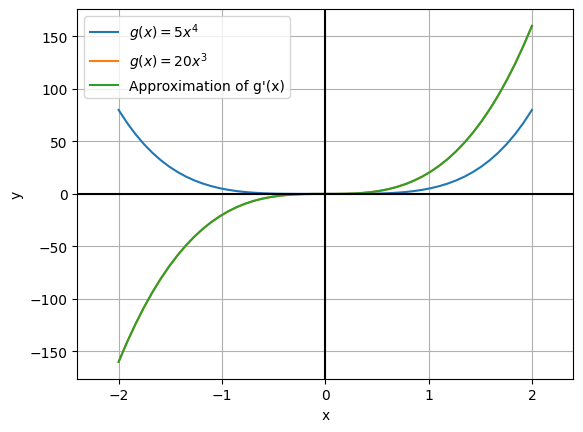

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fns.fnlib import get_rate_of_change_fn

def g(x):
    """$ g(x) = 5x^4 $"""
    return 5 * x ** 4

def g_derivative(x):
    """$ g(x) = 20x^3 $"""
    return 20 * x ** 3

g_derivative_approx = get_rate_of_change_fn(g)

x_min = -2
x_max = 2

xs = np.linspace(x_min, x_max)
_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(x_min - (x_max - x_min) * 0.1, x_max + (x_max - x_min) * 0.1)


ax.plot(xs, [g(x) for x in xs], label=g.__doc__)
ax.plot(xs, [g_derivative(x) for x in xs], label=g_derivative.__doc__)
ax.plot(xs, [g_derivative_approx(x) for x in xs], label="Approximation of g'(x)")


ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.legend()
plt.show()

Note that a linear function like $ f(x) = mx + n $ can be also expressed in terms of powers: $ f(x) = mx^1 + n $, and thus, $ f'(x) = 1 \cdot m \cdot x^0 = m $.

### Derivatives of transformed functions

Adding a constant to a function never changes its derivative. For example, if $ f(x) = x^{100} $, $ f'(x) = 100 \cdot x^{99} $, and the derivative of $ x^{100} - \pi $ is also $ 100 \cdot x^{99} $.

However, some modifications of the function have an influence in the derivative. For example, if you put a negative sign in front of a function, the graph flips upside down and so does the graph of any secant line. That is, is the slope of the secant line was $ m $, after the flip it will be $ -m $.

The same turns out to be true for any constant. If you multiply $ f(x) $ by 4, the new function is four times steeper at every point, and therefore the derivative will be $ 4 \cdot f'(x) $.

When dealing with a function that adds two functions together $ h(x) = f(x) + g(x) $, the derivative will be the sum of each derivative. For example, if $ h(x) = x^2 + x^3 $, the derivative is $ 2x + 3x^2 $.

### Derivatives of some special functions

Some functions cannot be written as transformed functions of simpler ones (e.g., $ sin(x) $, $ ln(x) $, etc.). For those, Calculus can be used to find its derivatives, but that is outside of the scope of this chapter.

The following table illustrates the derivatives for the most common functions:

| Function | Derivative |
| :-------: | :---------: |
| $ sin(x) $ | $ cos(x) $ |
| $ cos(x) $ | $ -sin(x) $ |
| $ e^x $ | $ e^x $ |
| $ a^x $ | $ ln(a) \cdot a^x $ |
| $ ln(x) $ | $ \frac{1}{x} $ |
| $ log_a (x) $| $ \frac{1}{ln(a) \cdot x} $ |

This table, along with the rules explained in the previous section, will allow you figure out more complicated derivatives.

For example, if $ f(x) = 6x + 2 \cdot sin(x) + 5 \cdot e^x $, then $ f'(x) = 6 + 2 \cdot cos(x) + 5 \cdot e^x $.

### Derivatives of products and compositions

A function like $ f(x) = x^2 \cdot sin(x) $ can be written as a product of two other functions $ f(x) = g(x) \cdot h(x) $.

The product rule for derivatives establishes:

$$
\displaystyle
f'(x) = g'(x) \cdot h(x) + g(x) \cdot h'(x)
$$

We can use that formula then to calculate the derivative of $ f(x) = x^2 \cdot sin(x) $.

$ f'(x) = 2x \cdot sin(x) + x^2 \cdot cos(x) $

Another important rule tells us how to take derivatives of functions that result from the composition of other functions such as $ f(x) = ln(cos(x)) $.

We can write that function as $ f(x) = g(h(x)) $, where $ g(x) = ln(x) $ and $ h(x) = cos(x) $.

The chain rule for composition establishes that:

$$
\displaystyle
f'(x) = h'(x) \cdot g'(h(x))
$$

We can use the formula then to calculate the derivative of $ f(x) = ln(cos(x)) $:

$ f'(x) = -sin(x) \cdot \frac{1}{cos(x)} = -\frac{sin(x)}{cos(x)} = - tan(x) $

### Exercise

Show that the derivative of $ f(x) = x^5 $ is indeed $ f'(x) = 5x^4 $ by plotting the numerical derivative, alongside the symbolic derivative.

We can use the support functions we defined in `fns.fnlib`:

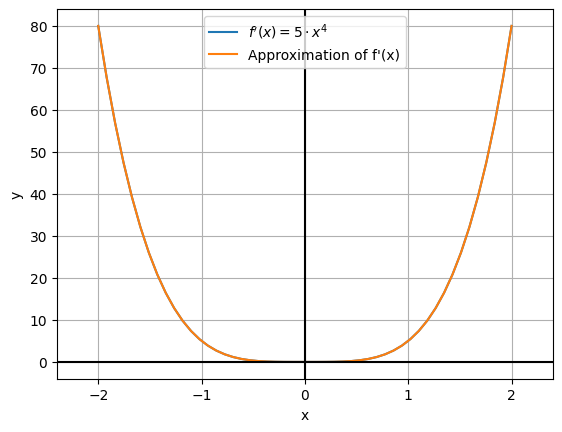

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from fns.fnlib import get_rate_of_change_fn

def f(x):
    """ f(x) = x^5 """
    return x ** 5

def f_derivative(x):
    """$ f'(x) = 5 \cdot x^4 $"""
    return 5 * x ** 4

f_derivative_approx = get_rate_of_change_fn(f)

x_min = -2
x_max = 2

xs = np.linspace(x_min, x_max)
_, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(x_min - (x_max - x_min) * 0.1, x_max + (x_max - x_min) * 0.1)


ax.plot(xs, [f_derivative(x) for x in xs], label=f_derivative.__doc__)
ax.plot(xs, [f_derivative_approx(x) for x in xs], label="Approximation of f'(x)")


ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.legend()
plt.show()

The two graphs overlap exactly.

### Exercise

Think again of the functions of one variable as a vector space as we did in a previous chapter. Explain why the rules for taking derivatives mean the derivative is a linear transformation of this vector space. 

| NOTE: |
| :---- |
| You have to restrict your attention to the functions that have derivatives everywhere. |

A linear transformation preserves linear combinations. In Mathematical terms, if $ L $ is the linear transformation, $ \vec{u} $ and $ \vec{v} $ are vectors of that space and $ a $, and $ b $ are scalars:

$
A(a \cdot \vec{u} + b \cdot \vec{v}) = a \cdot A(\vec{u}) + b \cdot A(\vec{v})
$

If we think of $ A $ as the derivative, and the vectors as functions, then, if $ h(x) = a \cdot f(x) + b \cdot g(x) $

$
h'(x) = a \cdot f'(x) + b \cdot g'(x)
$

which is exactly the formula we saw for the derivative of a sum of functions.


### Exercise

Find a formula for the derivative of a quotient $ f(x)/g(x) $.

A quotient is the same as $ f(x) \cdot \frac{1}{g(x)} = f(x) \cdot g(x)^{-1} $ and we've already discussed the the product rule for derivatives:

If $ h(x) = f(x) \cdot g(x) $

then

$
h'(x) = f'(x) \cdot g(x) + f(x) + g'(x)
$

We've also talked about the chain rule:

if $ f(x) = g(h(x)) $, then

$
f'(x) = g'(h(x)) \cdot h'(x)
$


And the power law for derivatives:

if $ f(x) = x^n $, then

$
f'(x) = n \cdot x^{n-1}
$


We need to apply the three rules to get the formula for the derivative of a quotient.

On one hand, we need to calculate, $ \frac{d}{dx}(g(x)^{-1}) $. This needs to be written as a composition:

if $ f(x) = x $, then $ g(x)^{-1} $ can be written as $ g(f(x))^{-1} $, which means that

$
(g(x)^{-1})' = -1 \cdot g(x)^{-2} \cdot g'(x) = \frac{g'(x)}{g(x)^2}
$

Then, we can finally find the formula:

$
\frac{f(x)}{g(x)} = f(x) \cdot g(x)^{-1} \\
= f'(x) \cdot g(x)^{-1} + f(x) \cdot (-1) \cdot g(x)^{-2} \cdot g'(x) \\
= \frac{f'(x)}{g(x)} - \frac{f(x) \cdot g'(x)}{g(x)^2} \\
= \frac{f'(x) \cdot g(x)}{g(x)^2} - \frac{f(x) \cdot g'(x)}{g(x)^2} \\
= \frac{f'(x) \cdot g(x) - f(x) \cdot g'(x)}{g(x)^2}
$

### Exercise

What is the derivative of $ sin(x) \cdot cos(x) \cdot ln(x) $?

We've already established that if $ h(x) = f(x) \cdot g(x) $, then $ h'(x) = f'(x) \cdot g(x) + f(x) \cdot g'(x) $.

And we know of the associative property in products:

$
a \cdot b \cdot c = a \cdot (b \cdot c) = (a \cdot b) \cdot c
$

Thus, we can write:

$ 
(sin(x) \cdot cos(x) \cdot ln(x))' \\
= ((sin(x) \cdot cos(x)) \cdot ln(x))' \\
= (sin(x) \cdot cos(x))' \cdot ln(x) + sin(x) \cdot cos(x) \cdot (ln(x))' \\
= (cos(x) \cdot cos(x) + sin(x) \cdot - sin(x)) \cdot ln(x) + sin(x) \cdot cos(x) \cdot \frac{1}{x} \\
= (cos(x)^2 - sin(x)^2) \cdot ln(x) + \frac{sin(x) \cdot cos(x)}{x}
$

### Exercise

Assume we know the derivatives of three functions $ f $, $ g $ and $ h $, which are written $ f' $, $ g' $, and $ h' $.

What is the derivative of $ f(g(h(x))) $?

Let's start inside out applying the chain rule and the other derivative rules we've already seen:

$
(g(h(x)))' = g'(h(x)) \cdot h'(x)
$

Thus,

$
(f(g(h(x)))) = f'(g(h(x))) \cdot (g(h(x)))' = f'(g(h(x))) \cdot g'(h(x)) \cdot h'(x)
$

## Taking derivatives automatically

In the previous sections we have established a few rules for taking derivatives that would let us calculate the derivatives of a lot of possible functions.

As long as the function is built from sums, products, powers, compositions, trigonometric, and exponential functions, we will be able to figure out its derivative.

| Name | Formula |
| :--- | :------ |
| Chain rule | $ (f(g(x)))' = f'(g(x)) \cdot g(x) $ |
| Product rule | $ (f(x) + g(x))' = f'(x) \cdot g(x) + f(x) \cdot g'(x) $ |
| Sum rule/linear combination | $ (a \cdot f(x) + b \cdot g(x))' = a \cdot f'(x) + b \cdot g'(x) $ |
| Power rule (generic) | $ (a \cdot f(x)^n)' = a \cdot f(x)^{n-1} \cdot f'(x) $ |
| Power rule (linear) | $ (a \cdot x^n + b)' = a \cdot n \cdot x^{n-1} $ |
| Derivative of a constant | $ a' = 0 $ |
| Derivative of sine | $ (sin(x))' = cos(x) $ |
| Derivative of cosine | $ (cos(x))' = -sin(x) $ |
| Derivative of exponential | $ (e^x)' = e^x $ |
| Derivative of exponential (base $ a $) | $ (a^x)' = ln(a) \cdot a^x $ |
| Derivative of natural logarithm | $ \displaystyle (ln(x))' = \frac{1}{x} $ |
| Derivative of base $ a $ logarithm | $ \displaystyle (log_a(x))' = \frac{1}{ln(a) \cdot x} $|



In order to implement this in our library we will need to match each case, be it either an element or a combinator, with the appropriate rule for taking its derivative. The end result should be a Python function that takes one expression and returns a new expression representing its derivative.

### Implementing a derivative method for expressions

You can find the code for taking the derivative in [symexpr: v2](../../02_mini-projects/26-symbolic-expr-v2/).

The idea is to define an abstract method `derivative()` at the `Expression` level and implement what it means to take the derivative in `Number`, `Variable`, `Sum`, `Product`, etc.

Additionally, a placeholder variable and a dictionary with the well-known derivatives needs to be created:

```python
_var = Variable("placeholder variable for derivatives")
_well_known_derivatives = {
    "sin": Apply(Function("cos"), _var),
    "cos": Negative(Apply(Function("sin"), _var)),
    "ln": Quotient(Number(1), _var),
}
```

Finally, to be able to change the placeholder variable for the proper one, another abstract method `substitute` needs to be defined in `Expression`.

With all this in place, you will be able to compute the derivatives automatically:

In [1]:
from symexpr import Product, Sum, Power, Variable, Function, Apply, Number

expr = Product(
        Sum(
            Product(Number(3), Power(Variable("x"), Number(2))),
            Variable("x"),
        ),
        Apply(Function("sin"), Variable("x")),
    )
expr

Product(Sum(Product(Number(3), Power(Variable(x), Number(2))), Variable(x)), Apply(Function('sin'), Variable(x)))

In [3]:
from symexpr import Product, Sum, Power, Variable, Function, Apply, Number

expr = Product(
        Sum(
            Product(Number(3), Power(Variable("x"), Number(2))),
            Variable("x"),
        ),
        Apply(Function("sin"), Variable("x")),
    )
expr.derivative(Variable("x"))

Sum(Product(Sum(Sum(Product(Number(0), Power(Variable(x), Number(2))), Product(Number(3), Product(Product(Number(2), Power(Variable(x), Number(1))), Number(1)))), Number(1)), Apply(Function('sin'), Variable(x))), Product(Sum(Product(Number(3), Power(Variable(x), Number(2))), Variable(x)), Product(Number(1), Apply(Function('cos'), Variable(x)))))

### Exercises

The code in [symexpr: v2](../../02_mini-projects/26-symbolic-expr-v2/) already handles the case where one expression making up a product is constant, meaning a product of the form $ c \cdot f(x) $ or $ f(x) \cdot c $ for some expression $ f(x) $. Either way, the derivative es $ f'(x) \cdot c $. You don't need the second term of the product rule, which is $ f(x) \cdot 0 = 0 $.

Update the code taking the derivative of a product to handle this case directly, rather than expanding the product rule and including a zero term.

Before applying the change we see the following:

In [2]:
from symexpr import Product, Variable

expr = Product(Variable("c"), Variable("x"))
expr.derivative(Variable("x"))


Sum(Product(Number(0), Variable(x)), Product(Variable(c), Number(1)))

After the modification, which consists in evaluating whether the left or right hand side of the expression is a number or a different variable, we get:

In [1]:
from symexpr import Product, Variable

expr = Product(Variable("c"), Variable("x"))
expr.derivative(Variable("x"))

Product(Variable(c), Number(1))

### Exercise

Add the square root function to the dictionary of known function and take its derivative automatically.

| Hint: |
| :---- |
| The square root of $ x $, $ \sqrt{x} $ is equal to $ x^{1/2} $. |

We just need to include `"sqrt"` in the derivatives:

```python
_well_known_derivatives = {
    "sqrt": Quotient(Number(1), Product(Number(2), Apply(Function("sqrt"), _var))),
}
```

Then:

In [1]:
from symexpr import Apply, Function, Variable

expr = Apply(Function("sqrt"), Variable("x"))
expr.derivative(Variable("x"))

Product(Number(1), Quotient(Number(1), Product(Number(2), Apply(Function('sqrt'), Variable(x)))))

## Integrating functions symbolically